## Import libraries

In [425]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import scipy.stats as stats
import importlib
import clean_functions as cl
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve 
from sklearn.metrics import roc_auc_score, f1_score, recall_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
import category_encoders as ce
import imblearn
import pickle
%pylab inline
pd.set_option('display.max_column',None)

Populating the interactive namespace from numpy and matplotlib


Load the cleaned DataFrame with features

## Exploratory Data Analysis

Load the cleaned DataFrame with features and check that the content has been correctly loaded

In [426]:
df_locals = pd.read_csv('Data/censolocales/locals_short.csv')
df_locals.head(2)

,desc_epigrafe,id_local,id_distrito_local,desc_distrito_local,id_barrio_local,desc_barrio_local,desc_tipo_acceso_local,id_situacion_local,desc_situacion_local,clase_vial_acceso,desc_vial_acceso,nom_acceso,num_acceso,cal_acceso,id_agrupacion,nombre_agrupacion,id_tipo_agrup,desc_tipo_agrup,rotulo,id_seccion,desc_seccion,id_division,desc_division,id_epigrafe,conc,desc_sit_loc_modif_19,desc_sit_loc_modif_18,desc_sit_loc_modif_17,desc_sit_loc_modif_16,desc_sit_loc_modif_15,cerrado_19,abierto_19,cerrado_18,abierto_18,cerrado_17,abierto_17,cerrado_16,abierto_16,target,desc_act_norm,id_act_norm,ab_17_19,loc_dist_act,ab_dist_act_17_19,total_loc_act,total_ab_act_17_19,loc_dist,ab_dist_17_19,loc_na_dist,ab_dist_act_17_19_rate,total_ab_act_17_19_rate,total_ab_dist_17_19_rate,total_na_dist_rate,loc_barrio_act,ab_barrio_act_17_19,loc_barrio,ab_barrio_17_19,loc_na_barrio,ab_barrio_act_17_19_rate,total_ab_barr_17_19_rate,total_na_barr_rate,num_act,coord_x_final,coord_y_final,lat,lon,Población,Hombre,Mujeres,Densidad (Habitantes / Ha.),Edad promedio,Total Hogares,Españoles,Extranjeros,Mixtos,España fuera barrio dia laboral,Extranjero fuera barrio dia laboral,Total fuera barrio dia laboral,España fuera barrio fin semana,Extranjero fuera barrio fin semana,Total fuera barrio fin semana,Total barrio dia laboral,Total barrio fin semana,Total trabajo dia laboral,Total trabajo fin semana,total_TF_week,ratio_t_total,ratio_fb_total,ratio_b_total,dist_type,points_in_radius
0,"COMERCIO AL POR MENOR DE PASTELERIA, CONFITERI...",10000102,1,CENTRO,106,SOL,Puerta Calle,1.0,Abierto,PLAZA,PUERTA DEL SOL ...,NUM,8,,-1.0,SIN AGRUPACION,-1.0,SIN AGRUPACION,LA MALLORQUINA,G,COMERCIO AL POR MAYOR Y AL POR MENOR; REPARACI...,47,"COMERCIO AL POR MENOR, EXCEPTO DE VEHICULOS DE...",472403,LA MALLORQUINA-PUERTA DEL SOL-8,Abierto,Abierto,Abierto,Abierto,Abierto,0,0,0,0,0,0,0,0,0,"COMERCIO AL POR MENOR DE PASTELERIA, CONFITERI...",472403,0,85,41.0,357,143.0,14344,2926,2166,48.235294,40.056022,20.398773,15.10039,8,3.0,1755,381,128,37.5,21.709402,7.293447,2,440208.59,4474240.53,40.416642,-3.704763,115198,58027,57171,257.985172,44.026383,67296,50164,8979,8153,1956512,348482,2304994,960027,169516,1129543,623007,241830,363775,110026,4773175,0.099263,0.71955,0.181187,1,16
1,"COMERCIO AL POR MENOR DE AVES, HUEVOS Y CAZA S...",10000162,1,CENTRO,104,JUSTICIA,Agrupado,1.0,Abierto,CALLE,BARCELO ...,NUM,6,,99000056.0,MERCADO MUNICIPAL DE BARCELO,12.0,Mercado Municipal,POLLERIAS RODRIGUEZ & MARTINEZ,G,COMERCIO AL POR MAYOR Y AL POR MENOR; REPARACI...,47,"COMERCIO AL POR MENOR, EXCEPTO DE VEHICULOS DE...",472206,POLLERIAS RODRIGUEZ & MARTINEZ-BARCELO-6,Abierto,Abierto,Abierto,Abierto,No disponible,0,0,0,0,0,0,0,1,0,"COMERCIO AL POR MENOR DE AVES, HUEVOS Y CAZA S...",472206,0,48,14.0,826,147.0,14344,2926,2166,29.166667,17.796610,20.398773,15.10039,6,0.0,2086,528,131,0.0,25.311601,6.279962,1,440692.59,4475369.53,40.426848,-3.699164,115198,58027,57171,257.985172,44.026383,67296,50164,8979,8153,1956512,348482,2304994,960027,169516,1129543,623007,241830,363775,110026,4773175,0.099263,0.71955,0.181187,1,5


### First a bit of cleaning on the 'raw file'
I do not expect to have nulls or incorrect type of variable since I ha donde so many cleaning on the real data.   
What I am going to do, in this part is:   
1) a 'wholesale' dropping variables that don't make sense to solve the problem   
2) train and test split: I will set aside a test set and training set. I will use CV in the model fiting     
3) Feature engineering based on train set to avoid data leakage   
4) Convert both training and test set to one with the appropriate features

#### 1) 'Wholesale' dropping of non interesting variables

In [427]:
# Till I solve how to keep unique ids, I drop the now the ids that are not unique. 
# I am dropping 25% of the dataset (7981 out of 10709). 
# 11% of id_local with more than a category associated (1019 out of 9000)
unique_ = df_locals.id_local.value_counts()
unique = unique_[unique_.values == 1]
no_unique = unique_[unique_.values > 1]
df_locals_ = df_locals[df_locals.id_local.isin(unique.index.values)]
cl.reset(df_locals_)
len(df_locals), len(df_locals.id_local.unique()),len(df_locals_), len(no_unique),df_locals_.shape

(10709, 9000, 7981, 1019, (7981, 91))

In [428]:
# I check the % of target vs total: improves in 3pp (having more than a category per local could be predictive)
len(df_locals[df_locals.target == 1])/len(df_locals), len(df_locals_[df_locals_.target == 1])/len(df_locals_)

(0.059856195723223454, 0.0637764691141461)

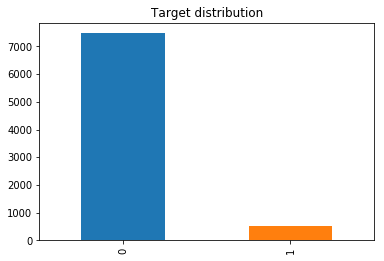

In [429]:
#Unbalanced distribution
plot = df_locals_['target'].value_counts().plot(kind='bar',
                                            title='Target distribution')

In [430]:
# My dataset has 91 columns. I will select the ones to work with
df_locals_.columns

Index(['desc_epigrafe', 'id_local', 'id_distrito_local', 'desc_distrito_local',
       'id_barrio_local', 'desc_barrio_local', 'desc_tipo_acceso_local',
       'id_situacion_local', 'desc_situacion_local', 'clase_vial_acceso',
       'desc_vial_acceso', 'nom_acceso', 'num_acceso', 'cal_acceso',
       'id_agrupacion', 'nombre_agrupacion', 'id_tipo_agrup',
       'desc_tipo_agrup', 'rotulo', 'id_seccion', 'desc_seccion',
       'id_division', 'desc_division', 'id_epigrafe', 'conc',
       'desc_sit_loc_modif_19', 'desc_sit_loc_modif_18',
       'desc_sit_loc_modif_17', 'desc_sit_loc_modif_16',
       'desc_sit_loc_modif_15', 'cerrado_19', 'abierto_19', 'cerrado_18',
       'abierto_18', 'cerrado_17', 'abierto_17', 'cerrado_16', 'abierto_16',
       'target', 'desc_act_norm', 'id_act_norm', 'ab_17_19', 'loc_dist_act',
       'ab_dist_act_17_19', 'total_loc_act', 'total_ab_act_17_19', 'loc_dist',
       'ab_dist_17_19', 'loc_na_dist', 'ab_dist_act_17_19_rate',
       'total_ab_act_17_19_r

I select the columns that makes sense from my point of view:    
- Fields related addresses, billboards,...    
- Have a numerical and name description (desc_ variable vs id_variable).    
- UTM coordinates (keeping lon and lat)   
- I remove 'id_local' for now because it will not be used in any of the prediction stages.

In [431]:
#Select the columns of interest and filter the DataFrame
columns_of_interest = ['id_distrito_local','id_barrio_local', 'id_epigrafe', 'target', 'ab_17_19', 
'loc_dist_act', 'ab_dist_act_17_19', 'total_loc_act', 'total_ab_act_17_19', 'loc_dist', 'ab_dist_17_19',
'loc_na_dist', 'ab_dist_act_17_19_rate', 'total_ab_act_17_19_rate', 'total_ab_dist_17_19_rate', 'total_na_dist_rate',
'loc_barrio_act', 'ab_barrio_act_17_19', 'loc_barrio', 'ab_barrio_17_19', 'loc_na_barrio', 'ab_barrio_act_17_19_rate',
'total_ab_barr_17_19_rate','total_na_barr_rate', 'lon', 'lat', 'num_act', 'Población', 'Hombre', 
'Mujeres', 'Densidad (Habitantes / Ha.)', 'Edad promedio', 'Total Hogares', 'Españoles', 'Extranjeros',
'España fuera barrio dia laboral', 'Extranjero fuera barrio dia laboral', 'Total fuera barrio dia laboral',
'España fuera barrio fin semana', 'Extranjero fuera barrio fin semana',
'Total fuera barrio fin semana', 'Total barrio dia laboral', 'Total barrio fin semana',
'Total trabajo dia laboral', 'Total trabajo fin semana', 'total_TF_week',
'ratio_t_total', 'ratio_fb_total', 'ratio_b_total', 'dist_type', 'points_in_radius']

df_locals_v2 = df_locals_[columns_of_interest]
df_locals_v2.shape

(7981, 51)

I still have too many variables (51). I will check correlations between dependent and independent variable to further filter those below average. In general, the correlation factor is quite low (below 6%)

In [432]:
correlations = df_locals_v2.corr()
correlations = correlations['target']
#variables = correlations[correlations.values > correlations.median()]
print(correlations)

id_distrito_local                      0.036192
id_barrio_local                        0.036129
id_epigrafe                            0.004739
target                                 1.000000
ab_17_19                              -0.034759
loc_dist_act                          -0.009032
ab_dist_act_17_19                      0.001651
total_loc_act                          0.002968
total_ab_act_17_19                    -0.001892
loc_dist                               0.015304
ab_dist_17_19                          0.017119
loc_na_dist                            0.017945
ab_dist_act_17_19_rate                 0.033176
total_ab_act_17_19_rate                0.005555
total_ab_dist_17_19_rate              -0.004614
total_na_dist_rate                     0.031622
loc_barrio_act                        -0.000036
ab_barrio_act_17_19                    0.007081
loc_barrio                             0.044751
ab_barrio_17_19                        0.027750
loc_na_barrio                          0

In [433]:
# Correlations
correlations = df_locals_v2.corr()
correlations = correlations['target']
variables = correlations[abs(correlations.values) > correlations.median()]
#print(correlations)
variables.sort_values(ascending=False)

target                                 1.000000
loc_na_barrio                          0.053921
total_na_barr_rate                     0.049260
loc_barrio                             0.044751
id_distrito_local                      0.036192
id_barrio_local                        0.036129
ab_dist_act_17_19_rate                 0.033176
total_na_dist_rate                     0.031622
ab_barrio_17_19                        0.027750
Extranjero fuera barrio fin semana     0.027171
Extranjero fuera barrio dia laboral    0.025925
lon                                    0.023694
loc_na_dist                            0.017945
ab_dist_17_19                          0.017119
dist_type                              0.016165
loc_dist                               0.015304
Extranjeros                            0.014000
ab_barrio_act_17_19_rate               0.013992
Total fuera barrio fin semana          0.012125
lat                                    0.009897
España fuera barrio fin semana         0

In [434]:
# Create the Dataframe with the most correlated to the target variables
df_locals_c = pd.DataFrame(df_locals_v2,columns = variables.index.values)
df_locals_c.shape

(7981, 42)

In [435]:
df_locals_c.columns

Index(['id_distrito_local', 'id_barrio_local', 'id_epigrafe', 'target',
       'ab_17_19', 'loc_dist_act', 'loc_dist', 'ab_dist_17_19', 'loc_na_dist',
       'ab_dist_act_17_19_rate', 'total_ab_act_17_19_rate',
       'total_ab_dist_17_19_rate', 'total_na_dist_rate', 'ab_barrio_act_17_19',
       'loc_barrio', 'ab_barrio_17_19', 'loc_na_barrio',
       'ab_barrio_act_17_19_rate', 'total_ab_barr_17_19_rate',
       'total_na_barr_rate', 'lon', 'lat', 'num_act', 'Población', 'Hombre',
       'Mujeres', 'Densidad (Habitantes / Ha.)', 'Edad promedio',
       'Total Hogares', 'Españoles', 'Extranjeros',
       'Extranjero fuera barrio dia laboral', 'Total fuera barrio dia laboral',
       'España fuera barrio fin semana', 'Extranjero fuera barrio fin semana',
       'Total fuera barrio fin semana', 'Total barrio dia laboral',
       'Total barrio fin semana', 'Total trabajo dia laboral',
       'Total trabajo fin semana', 'ratio_t_total', 'dist_type'],
      dtype='object')

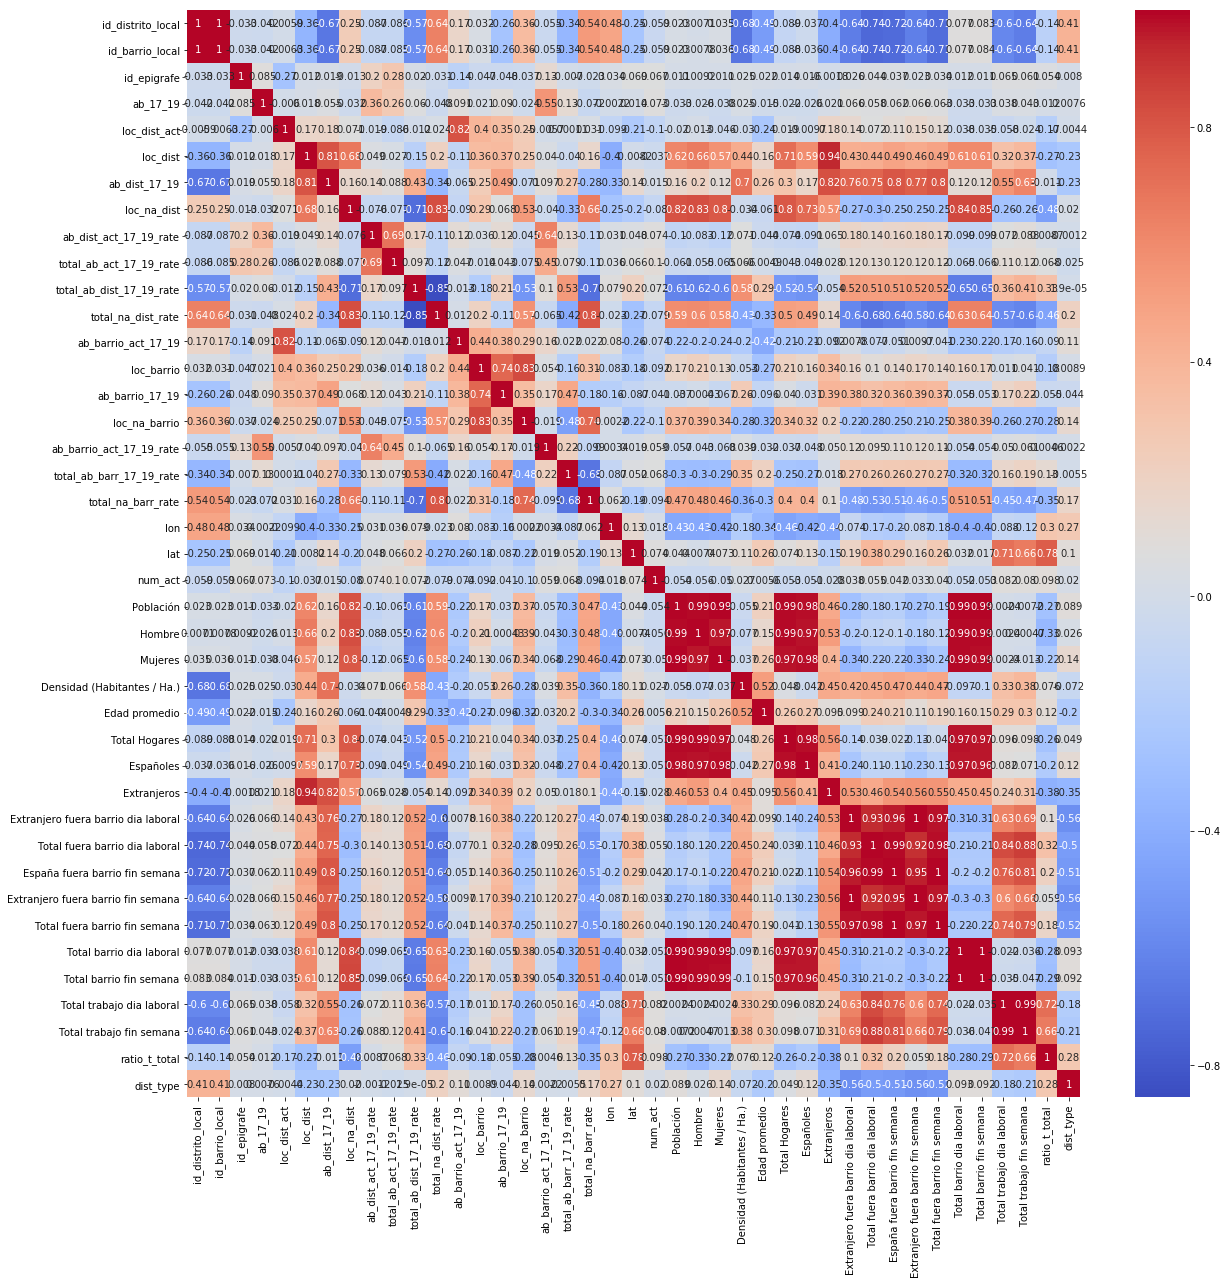

In [436]:
#Out of the chosen variables, I check the ones more correlated (>0.5) and drop also the ones 
#less correlated with target (id_)
plt.figure(figsize=(20,20))
sns.heatmap(df_locals_c.drop('target',axis=1).corr(),annot = True, cmap ='coolwarm')

Out of the chosen variables, I check the ones more correlated (>0.8) and drop also the ones less correlated with target

In [437]:
# Finally, I just keept 16 variables for modeling 
cols_drop = ['id_barrio_local', 'ab_barrio_act_17_19', 'loc_dist', 'loc_na_dist', 'loc_na_barrio', 
             'total_na_dist_rate', 'Población', 'Hombre','Total Hogares',
             'Extranjeros', 'Españoles', 
             'Extranjero fuera barrio dia laboral', 
             'España fuera barrio fin semana', 
             'Total fuera barrio dia laboral', 'Total fuera barrio fin semana',
             'Total trabajo dia laboral', 'Total trabajo fin semana',
             'Total barrio fin semana','Total barrio dia laboral']

df_locals_final = df_locals_c.drop(cols_drop, axis=1)


# I create X and y variables
X = df_locals_final.drop('target',axis=1)
y = df_locals_final['target']

X.columns, X.shape, len(y)

(Index(['id_distrito_local', 'id_epigrafe', 'ab_17_19', 'loc_dist_act',
        'ab_dist_17_19', 'ab_dist_act_17_19_rate', 'total_ab_act_17_19_rate',
        'total_ab_dist_17_19_rate', 'loc_barrio', 'ab_barrio_17_19',
        'ab_barrio_act_17_19_rate', 'total_ab_barr_17_19_rate',
        'total_na_barr_rate', 'lon', 'lat', 'num_act', 'Mujeres',
        'Densidad (Habitantes / Ha.)', 'Edad promedio',
        'Extranjero fuera barrio fin semana', 'ratio_t_total', 'dist_type'],
       dtype='object'), (7981, 22), 7981)

#### 2) train and test split: I will set aside a test set and training set. I will use CV in the model fiting

In [547]:
# train and test split
X_train_, X_test_, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=42)

#### 3) Feature engineering based on train set to avoid data leakage
Reference: https://medium.com/vickdata/four-feature-types-and-how-to-transform-them-for-machine-learning-8693e1c24e80. Some of the functions of the following steps are taken from this article.

In [442]:
def quick_analysis(df):
    print('Data Types:')
    print(df.dtypes)
    print('Rows and Columns:')
    print(df.shape)
    print('Column Names:')
    print(df.columns)
    print('Null Values:')
    print(df.apply(lambda x: sum(x.isnull()) / len(df)))
quick_analysis(X_train_)

Data Types:
id_distrito_local                       int64
id_epigrafe                             int64
ab_17_19                                int64
loc_dist_act                            int64
ab_dist_17_19                           int64
ab_dist_act_17_19_rate                float64
total_ab_act_17_19_rate               float64
total_ab_dist_17_19_rate              float64
loc_barrio                              int64
ab_barrio_17_19                         int64
ab_barrio_act_17_19_rate              float64
total_ab_barr_17_19_rate              float64
total_na_barr_rate                    float64
lon                                   float64
lat                                   float64
num_act                                 int64
Mujeres                                 int64
Densidad (Habitantes / Ha.)           float64
Edad promedio                         float64
Extranjero fuera barrio fin semana      int64
ratio_t_total                         float64
dist_type             

After the train-test split, I have a dataset of 5586 rows and 23 columns. All of the features are numeric although some of then are nominal variables or categories. I will have to do some transformation prior to the modeling.   
I confirm that there are no null values so I don’t need to treat those.

In [443]:
X_train_.describe()

,id_distrito_local,id_epigrafe,ab_17_19,loc_dist_act,ab_dist_17_19,ab_dist_act_17_19_rate,total_ab_act_17_19_rate,total_ab_dist_17_19_rate,loc_barrio,ab_barrio_17_19,ab_barrio_act_17_19_rate,total_ab_barr_17_19_rate,total_na_barr_rate,lon,lat,num_act,Mujeres,Densidad (Habitantes / Ha.),Edad promedio,Extranjero fuera barrio fin semana,ratio_t_total,dist_type
count,5586.000000,5586.000000,5586.000000,5586.000000,5586.000000,5586.000000,5586.000000,5586.000000,5586.000000,5586.000000,5586.000000,5586.000000,5586.000000,5586.000000,5586.000000,5586.000000,5586.000000,5586.000000,5586.000000,5586.000000,5586.000000,5586.000000
mean,9.629968,591665.166130,0.251522,44.349982,1518.556570,25.793200,25.965586,16.654228,1909.595596,313.456140,25.539791,16.938968,24.996034,-3.687896,40.417959,1.368600,72610.924275,165.746081,44.157447,35710.504117,0.110557,2.306122
std,5.705141,202726.129652,0.433927,40.062290,634.121029,15.330817,10.557865,3.656951,995.101238,185.481841,23.778919,6.498320,11.644287,0.039419,0.034424,0.737784,21365.207782,92.999392,2.034342,48022.593043,0.020977,0.797324
min,1.000000,463101.000000,0.000000,1.000000,449.000000,0.000000,12.228797,10.538521,26.000000,1.000000,0.000000,3.846154,3.846154,-3.814394,40.334789,1.000000,19080.000000,10.344042,38.825609,2035.000000,0.083173,1.000000
25%,5.000000,472206.000000,0.000000,19.000000,1097.000000,14.285714,17.796610,13.758581,1213.000000,184.000000,0.000000,12.171634,16.123499,-3.709775,40.392174,1.000000,57171.000000,73.749778,42.867631,7104.000000,0.092633,2.000000
50%,10.000000,472404.000000,0.000000,35.000000,1443.000000,23.076923,23.726542,15.395868,1642.000000,270.000000,22.222222,16.166884,23.340471,-3.696171,40.417429,1.000000,66949.000000,179.359836,44.126744,19866.000000,0.101085,3.000000
75%,15.000000,750003.000000,1.000000,53.000000,1761.000000,35.166240,32.761087,20.398773,2651.000000,402.000000,40.000000,20.702465,33.988846,-3.661001,40.439681,2.000000,96250.000000,257.985172,46.241563,39454.000000,0.129359,3.000000
max,21.000000,960902.000000,1.000000,219.000000,2926.000000,100.000000,54.435484,23.110721,4448.000000,825.000000,100.000000,100.000000,53.421053,-3.542067,40.532730,8.000000,105519.000000,298.017711,47.545059,169516.000000,0.146505,3.000000


To categorise the variable types, I run the following code which produces histograms of all the numerical features. From the resulting output you can see features that are continuous, dichotomous and from my knowledge of the dataset, some nominal variables.

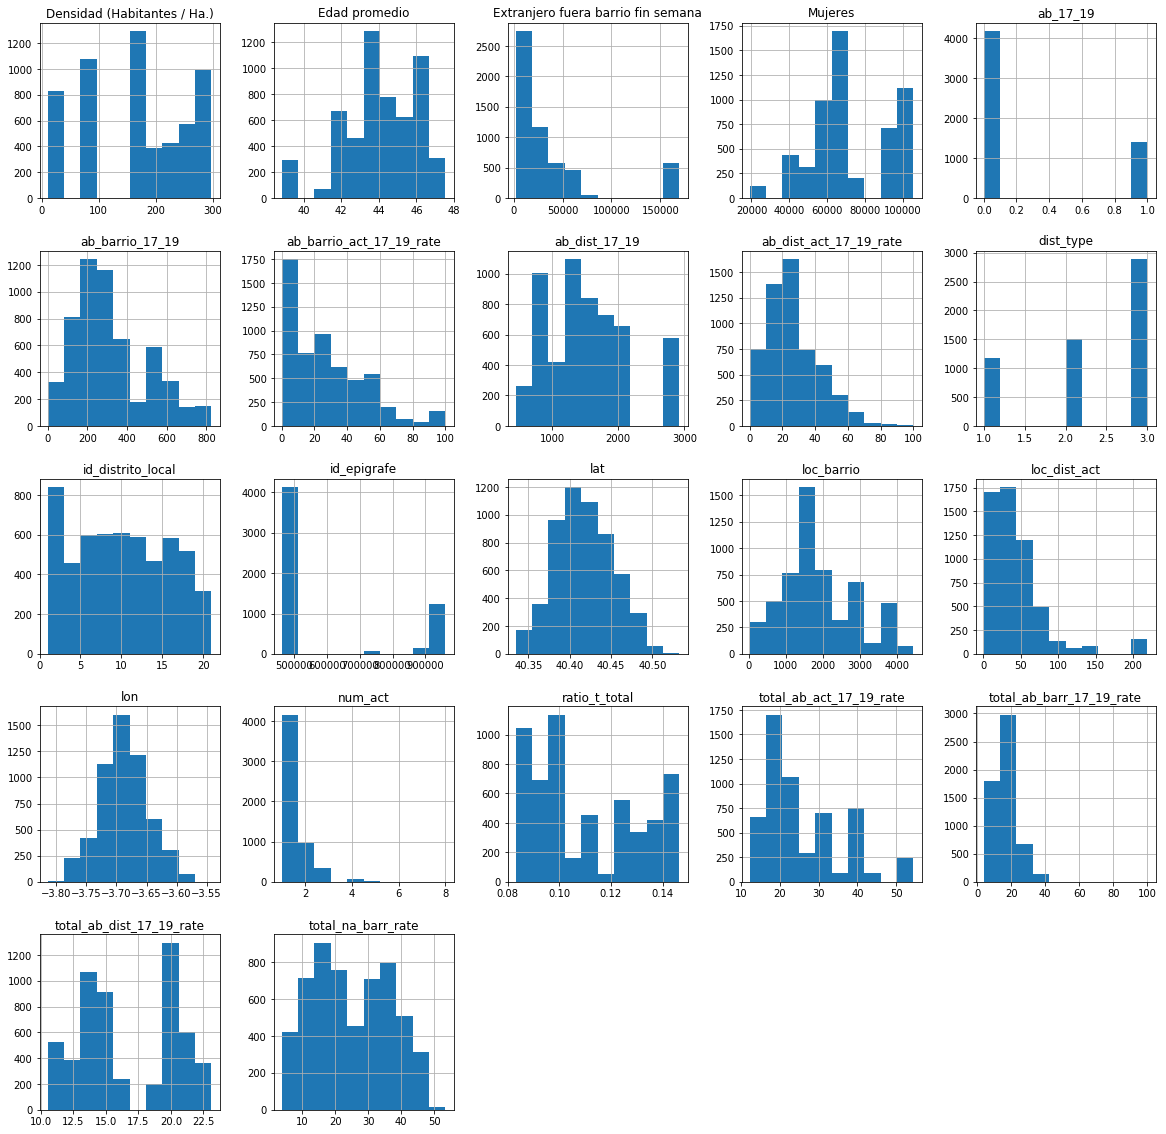

In [444]:
X_train_[X_train_.dtypes[(X_train_.dtypes=="float64")|(X_train_.dtypes=="int64")]
                        .index.values].hist(figsize=[20,20]);

I characterized the features into the following types:   
- **Continous**: 'loc_dist_act', 'ab_dist_17_19', 'ab_dist_act_17_19_rate', 'total_ab_act_17_19_rate', 'total_ab_dist_17_19_rate', 'loc_barrio', 'ab_barrio_17_19', 'ab_barrio_act_17_19_rate',        'total_ab_barr_17_19_rate', 'total_na_barr_rate', 'lon', 'lat', 'num_act', 'Mujeres', 'Densidad (Habitantes / Ha.)', 'Edad promedio', 'Extranjero fuera barrio fin semana', 'ratio_t_total'   
- **Dichotomous**: ab_17_19   
- **Nominal**: 'id_distrito_local', 'id_epigrafe', 'dist_type'

I will scale the continous variables and encode the nominal variable. For this I will take as reference the code and article: https://towardsdatascience.com/an-easier-way-to-encode-categorical-features-d840ff6b3900

##### 4) Convert both training and test set to one with the appropriate features: Scaling and encoding

In [548]:
# id_epigrafe: 25 values; id_distrito_local: 21 values, dist_type: 3 values
len(X_train_.id_epigrafe.unique()), len(X_train_.id_distrito_local.unique()), len(X_train_.dist_type.unique())

(25, 21, 3)

In [447]:
# categorical and numerical features
cat_feature = ['id_distrito_local', 'id_epigrafe', 'dist_type','ab_17_19']
num_feature = ['loc_dist_act', 'ab_dist_17_19', 'ab_dist_act_17_19_rate', 
               'total_ab_act_17_19_rate', 'total_ab_dist_17_19_rate', 'loc_barrio', 
               'ab_barrio_17_19', 'ab_barrio_act_17_19_rate', 'total_ab_barr_17_19_rate', 
               'total_na_barr_rate', 'lon', 'lat', 'num_act', 'Mujeres', 
               'Densidad (Habitantes / Ha.)', 'Edad promedio', 
               'Extranjero fuera barrio fin semana', 'ratio_t_total']

In [549]:
# Funcion that encodes (Pandas dummies) and scales
# I have selected dummies to keep columns names easily

def enc_scaler_train(df, scaler_func, cat_features, num_features):
    #Encoding
    df_ = pd.get_dummies(df, columns = cat_features)
    
    #Scaling
    num_feature = num_features
    num_s = df_[num_feature]
    scaler = scaler_func()
    x_scaled = scaler.fit_transform(num_s.values)
    num_s = pd.DataFrame(x_scaled, columns=num_feature,index=df_.index.values)
    cat_ = df_.drop(num_feature, axis=1)
    df__ = pd.concat([num_s, cat_], axis=1)
    return df__,scaler

# this function recover the scaler fit with train
def enc_scaler_test(df, scaler, cat_features, num_features):
    #Encoding
    df_ = pd.get_dummies(df, columns = cat_features)
    
    #Scaling
    num_feature = num_features
    num_s = df_[num_feature]
    scaler = scaler
    x_scaled = scaler.transform(num_s.values)
    num_s = pd.DataFrame(x_scaled, columns=num_feature, index=df_.index.values)
    cat_ = df_.drop(num_feature, axis=1)
    df__ = pd.concat([num_s, cat_], axis=1)
    return df__

In [550]:
X_train, scaler = enc_scaler_train(X_train_, StandardScaler,cat_feature,num_feature)
X_test = enc_scaler_test(X_test_, scaler,cat_feature,num_feature)

## Modeling

**A) Base model**: Logistic Regression

**B) Other models to test**: Random Forest, XGboost

**C) Metrics**: Recall, Precision & Recal curve, AUC, f1_score

**D) Managing imabalanced data**:   
Since it is an imbalanced dataset, I am going to test two types to manage it:   
- Class_weight: no resampling, simply make the classifier aware of imbalanced data by incorporating the weights of the classes into the cost function   
- SMOTE: Synthetic Minority Over-sampling Technique: up-sampling with new synthetic data at some distance from real minority data and one of their neighbours   

I will make the test with Logistic Regression   

**F) Modelling Steps**:   
1) Generate Classifier (Gridsearch for Random Forest and XGboost)   
2) Fit   
3) Metrics 
4) Compare results   
5) Feature importance (random forest, xGBoost)   
6) Cut off analysis   

In [450]:
# Load the library
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve, roc_auc_score, f1_score
from sklearn.pipeline import Pipeline
import imblearn

### A.1) Logistic regression classifier (with class_weight imbalanced management)

#### 1) Classifier

I fit several models varying the inverse-regularization parameter C to get LogisticRegression to converge (with C=1.0 by default there was a warning of lbfgs failed to converge)

In [534]:
logreg = LogisticRegression(C=0.01,solver='lbfgs',
                            class_weight='balanced',
                            random_state=42)

#### **2) Fit the model**

In [535]:
logreg.fit(X_train,y_train)

LogisticRegression(C=0.01, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

**3) Metrics** 

In [536]:
#predict class values
pred = logreg.predict(X_test)
#confussion matrix
print(confusion_matrix(y_test,pred))
print(classification_report(y_test,pred))

[[1427  817]
 [  54   97]]
              precision    recall  f1-score   support

           0       0.96      0.64      0.77      2244
           1       0.11      0.64      0.18       151

    accuracy                           0.64      2395
   macro avg       0.53      0.64      0.47      2395
weighted avg       0.91      0.64      0.73      2395



**Roc - Auc**     
I found and interesting article with some code that I will use in my Notebook:https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/
For imbalanced dataset as in my case, we should take precision-recall curves measures instead of roc curves

No Skill: ROC AUC=0.500
Logistic_cw: ROC AUC=0.684


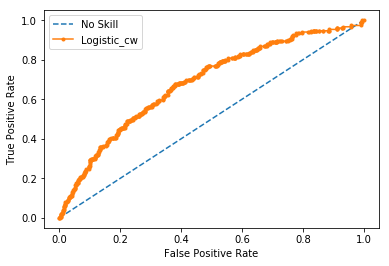

In [537]:
# generate a no skill prediction (majority class)
ns_prob = [0 for _ in range(len(y_test))]
# predict probabilities
pred_prob_cw = logreg.predict_proba(X_test)
# keep probabilities for the positive outcome only
lr_prob_cw = pred_prob_cw[:,1]
#calculate scores
ns_auc = roc_auc_score(y_test, ns_prob)
lr_auc_roc_cw = roc_auc_score(y_test, lr_prob_cw)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic_cw: ROC AUC=%.3f' % (lr_auc_roc_cw))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_prob)
lr_fpr_cw, lr_tpr_cw, _ = roc_curve(y_test, lr_prob_cw)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr_cw, lr_tpr_cw, marker='.', label='Logistic_cw')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

**Precision-recall curve**  
We leave aside the effect of the True Negatives and see we are not predicting at all. 
We can see that the model is penalized for predicting the majority class in all cases. The scores show that the model that looked good according to the ROC Curve is in fact barely skillful when considered using using precision and recall that focus on the positive class.  The plot of the precision-recall curve highlights that the model is just barely above the no skill line for most thresholds.
This is possible because the model predicts probabilities and is uncertain about some cases. These get exposed through the different thresholds evaluated in the construction of the curve, flipping some class 0 to class 1, offering some precision but very low recall.
We take out the effect of the True Negatives and see we are not predicting at all
References: :https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/ 

Logistic_cw: f1=0.182 auc=0.123


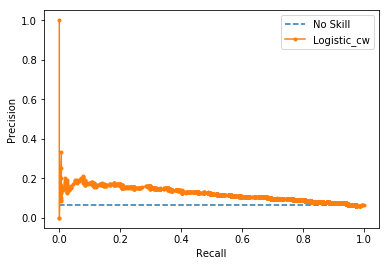

In [538]:
# precision, recall and f1
lr_precision_cw, lr_recall_cw, _cw = precision_recall_curve(y_test, lr_prob_cw)
lr_f1_cw, lr_auc_cw = f1_score(y_test, pred), auc(lr_recall_cw, lr_precision_cw)
# summarize scores
print('Logistic_cw: f1=%.3f auc=%.3f' % (lr_f1_cw, lr_auc_cw))
# plot the precision-recall curves
no_skill = len(y_test[y_test==1]) / len(y_test)
pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
pyplot.plot(lr_recall_cw, lr_precision_cw, marker='.', label='Logistic_cw')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

**Results**  
I will load the results in a DataFrame to compare the outputs of different models.   
I am going to test Logistic Regression with SMOTE, Random Forest basic and tuned and Xgboost basic and tuned

In [539]:
result = pd.DataFrame(index=['recall', 'auc_roc','auc_prec_rec','f1'])
result['logreg_cw'] = [cross_val_score(logreg,X,y,scoring='recall',cv=5).mean(),lr_auc_roc_cw,lr_auc_cw,lr_f1_cw]

/home/dsc/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/dsc/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/dsc/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [540]:
result

,logreg_cw
recall,0.485479
auc_roc,0.683655
auc_prec_rec,0.123323
f1,0.182160


### B.1) Logistic regression classifier (with SMOTE imbalanced management)

In [459]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline 

#### 1) Classifier

In [551]:
# I generate a Pipeline manage the imbalance with SMOTE library of imblearn

smt = SMOTE(random_state=42)
logreg_sm = Pipeline([('imbalance',smt),
                      ('classifier', LogisticRegression(solver='lbfgs',
                                                        C=0.01,
                                                        random_state=42))])

#### **2) Fit the model**

In [552]:
logreg_sm.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('imbalance',
                 SMOTE(k_neighbors=5, kind='deprecated',
                       m_neighbors='deprecated', n_jobs=1,
                       out_step='deprecated', random_state=42, ratio=None,
                       sampling_strategy='auto', svm_estimator='deprecated')),
                ('classifier',
                 LogisticRegression(C=0.01, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='warn', n_jobs=None,
                                    penalty='l2', random_state=42,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

**3) Metrics** 

In [553]:
#predict class values
pred_sm = logreg_sm.predict(X_test)
#confussion matrix
print(confusion_matrix(y_test,pred_sm))
print(classification_report(y_test,pred_sm))

[[1370  874]
 [  57   94]]
              precision    recall  f1-score   support

           0       0.96      0.61      0.75      2244
           1       0.10      0.62      0.17       151

    accuracy                           0.61      2395
   macro avg       0.53      0.62      0.46      2395
weighted avg       0.91      0.61      0.71      2395



**Roc - Auc**

No Skill: ROC AUC=0.500
Logistic_cw: ROC AUC=0.684
Logistic_sm: ROC AUC=0.674


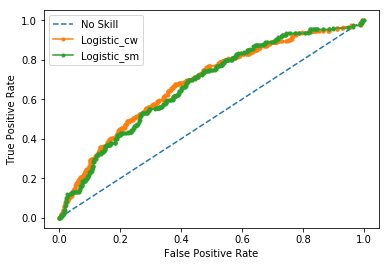

In [555]:
# generate a no skill prediction (majority class)
ns_prob = [0 for _ in range(len(y_test))]
# predict probabilities
pred_prob_sm = logreg_sm.predict_proba(X_test)
# keep probabilities for the positive outcome only
lr_prob_sm = pred_prob_sm[:,1]
#calculate scores
ns_auc = roc_auc_score(y_test, ns_prob)
lr_auc_roc_sm = roc_auc_score(y_test, lr_prob_sm)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic_cw: ROC AUC=%.3f' % (lr_auc_roc_cw))
print('Logistic_sm: ROC AUC=%.3f' % (lr_auc_roc_sm))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_prob)
lr_fpr_sm, lr_tpr_sm, _sm = roc_curve(y_test, lr_prob_sm)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr_cw, lr_tpr_cw, marker='.', label='Logistic_cw')
pyplot.plot(lr_fpr_sm, lr_tpr_sm, marker='.', label='Logistic_sm')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

**Precision-recall curve**

Logistic: f1=0.182 auc=0.123
Logistic: f1=0.168 auc=0.115


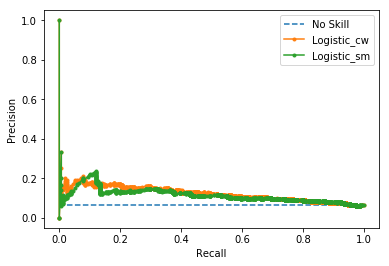

In [556]:
# precision, recall and f1
lr_precision_sm, lr_recall_sm, _sm = precision_recall_curve(y_test, lr_prob_sm)
lr_f1_sm, lr_auc_sm = f1_score(y_test, pred_sm), auc(lr_recall_sm, lr_precision_sm)
# summarize scores
print('Logistic: f1=%.3f auc=%.3f' % (lr_f1_cw, lr_auc_cw))
print('Logistic: f1=%.3f auc=%.3f' % (lr_f1_sm, lr_auc_sm))
# plot the precision-recall curves
no_skill = len(y_test[y_test==1]) / len(y_test)
pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
pyplot.plot(lr_recall_cw, lr_precision_cw, marker='.', label='Logistic_cw')
pyplot.plot(lr_recall_sm, lr_precision_sm, marker='.', label='Logistic_sm')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [557]:
result['logreg_sm'] = [cross_val_score(logreg_sm,X,y,scoring='recall',cv=5).mean(),lr_auc_roc_sm,lr_auc_sm,lr_f1_sm]

/home/dsc/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Comparing class_weight with SMOTE, results are worst with the second, all the metrics are worse   
The model is not far from random

In [558]:
result

,logreg_cw,logreg_sm
recall,0.485479,0.436362
auc_roc,0.683655,0.674220
auc_prec_rec,0.123323,0.114851
f1,0.182160,0.168007


## B.1) Random Forest

### Without Randomized search 
Some chosen parameter from experience (basic)

In [468]:
# Import library
from sklearn.ensemble import RandomForestClassifier
import pickle

#### 1) Classifier

In [559]:
# With best parameters
clf_rfb = RandomForestClassifier(n_estimators=500,
                                 min_samples_leaf=14,
                                 max_features='auto',
                                 max_depth=3,
                                 class_weight='balanced',
                                random_state=42)

#### **2) Fit the model**

In [560]:
clf_rfb.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=3, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=14,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=500, n_jobs=None, oob_score=False,
                       random_state=42, verbose=0, warm_start=False)

#### 3) Metrics

In [514]:
#predict class values
pred_rfb = clf_rfb.predict(X_test)
#confussion matrix
print(confusion_matrix(y_test,pred_rfb))
print(classification_report(y_test,pred_rfb))

[[1438  806]
 [  56   95]]
              precision    recall  f1-score   support

           0       0.96      0.64      0.77      2244
           1       0.11      0.63      0.18       151

    accuracy                           0.64      2395
   macro avg       0.53      0.63      0.48      2395
weighted avg       0.91      0.64      0.73      2395



**Roc - Auc**

No Skill: ROC AUC=0.500
Logistic_cw: ROC AUC=0.684
Logistic_sm: ROC AUC=0.674
Random_forest_basic: ROC AUC=0.693


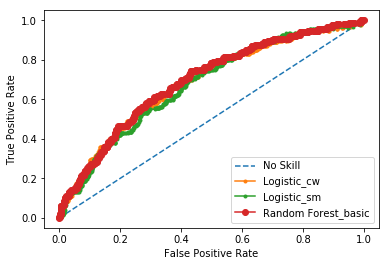

In [561]:
# predict probabilities
rf_probb = clf_rfb.predict_proba(X_test)
# keep probabilities for the positive outcome only
rf_probb = rf_probb[:,1]
#calculate scores
rf_auc_rocb = roc_auc_score(y_test, rf_probb)
# summarize scores and compare with previous classifiers
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic_cw: ROC AUC=%.3f' % (lr_auc_roc_cw))
print('Logistic_sm: ROC AUC=%.3f' % (lr_auc_roc_sm))
print('Random_forest_basic: ROC AUC=%.3f' % (rf_auc_rocb))
# calculate roc curves
rf_fprb, rf_tprb, _rfb = roc_curve(y_test, rf_probb)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr_cw, lr_tpr_cw, marker='.', label='Logistic_cw')
pyplot.plot(lr_fpr_sm, lr_tpr_sm, marker='.', label='Logistic_sm')
pyplot.plot(rf_fprb, rf_tprb, marker='o', label='Random Forest_basic')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

**Precision-recall** 

Logistic: f1=0.182 auc=0.123
Logistic: f1=0.168 auc=0.115
Random Forest_basic: f1=0.181 auc=0.143


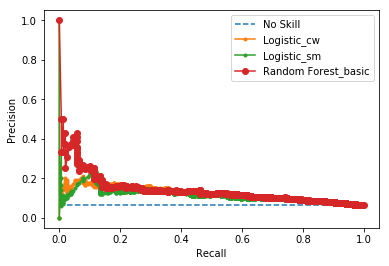

In [567]:
# precision, recall and f1
rf_precisionb, rf_recallb, _rf_prb = precision_recall_curve(y_test, rf_probb)
rf_f1b, rf_aucb = f1_score(y_test, pred_rfb), auc(rf_recallb, rf_precisionb)
# summarize scores
print('Logistic: f1=%.3f auc=%.3f' % (lr_f1_cw, lr_auc_cw))
print('Logistic: f1=%.3f auc=%.3f' % (lr_f1_sm, lr_auc_sm))
print('Random Forest_basic: f1=%.3f auc=%.3f' % (rf_f1b, rf_aucb))
# plot the precision-recall curves
pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
pyplot.plot(lr_recall_cw, lr_precision_cw, marker='.', label='Logistic_cw')
pyplot.plot(lr_recall_sm, lr_precision_sm, marker='.', label='Logistic_sm')
pyplot.plot(rf_recallb, rf_precisionb, marker='o', label='Random Forest_basic')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [587]:
result['clf_rf_basic'] = [cross_val_score(clf_rfb,X,y,scoring='recall',cv=5).mean(),rf_auc_rocb,rf_aucb,rf_f1b]

I have improved the recall and the auc_prec_rec but slightly. Let's tune it a little bit

In [588]:
result

,logreg_cw,logreg_sm,clf_rf_basic,clf_rf_tuned,clf_xgb_basic,clf_xgb_tuned
recall,0.485479,0.436362,0.570025,0.575927,0.070608,0.107921
auc_roc,0.683655,0.674220,0.693077,0.686995,0.708398,0.721943
auc_prec_rec,0.123323,0.114851,0.143199,0.135815,0.217349,0.221856
f1,0.182160,0.168007,0.180608,0.184466,0.195652,0.204878


## B.2) Random Forest

### RandomizedSearch

In [476]:
# Import library
from sklearn.ensemble import RandomForestClassifier
import pickle

#### 1) Classifier

In [477]:
# I don't further need the pipe (imputer and scaling is done before) 
# I keep it for the future
pipe_rf = Pipeline([('classifier', RandomForestClassifier(class_weight='balanced'))
                  ])

param_grid={'classifier__n_estimators':np.arange(200,2000,200),
            'classifier__max_features':['auto','log2'],
            'classifier__max_depth':np.arange(3,10),          
            'classifier__min_samples_leaf': np.arange(10,30)
                         }
# I do a RandomizedSearch for the seek of timing and process performance.
# I will evaluate later whether a Gridsearch is needed for further fine tuning of parameters
clf_rf = RandomizedSearchCV(pipe_rf,param_grid,n_iter=100,cv = 5,
                            iid=True,verbose=2,random_state=42,
                            n_jobs = -1, scoring = 'recall')

#### **2) Fit the model**

In [478]:
clf_rf.fit(X_train,y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed: 11.7min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 16.3min finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=Pipeline(memory=None,
                                      steps=[('classifier',
                                              RandomForestClassifier(bootstrap=True,
                                                                     class_weight='balanced',
                                                                     criterion='gini',
                                                                     max_depth=None,
                                                                     max_features='auto',
                                                                     max_leaf_nodes=None,
                                                                     min_impurity_decrease=0.0,
                                                                     min_impurity_split=None,
                                                                     min_samples_leaf=1,
                     

In [570]:
# hiperparámetros
clf_rf.best_params_, clf_rf.best_score_

({'classifier__n_estimators': 800,
  'classifier__min_samples_leaf': 21,
  'classifier__max_features': 'log2',
  'classifier__max_depth': 3},
 0.5781745611513693)

In [571]:
#predict class values
pred_rf = clf_rf.best_estimator_.predict(X_test)
#confussion matrix
print(confusion_matrix(y_test,pred_rf))
print(classification_report(y_test,pred_rf))

[[1460  784]
 [  56   95]]
              precision    recall  f1-score   support

           0       0.96      0.65      0.78      2244
           1       0.11      0.63      0.18       151

    accuracy                           0.65      2395
   macro avg       0.54      0.64      0.48      2395
weighted avg       0.91      0.65      0.74      2395



**Roc - Auc**

No Skill: ROC AUC=0.500
Logistic_cw: ROC AUC=0.684
Logistic_sm: ROC AUC=0.674
Random_forest_basic: ROC AUC=0.693
Random_forest_tuned: ROC AUC=0.687


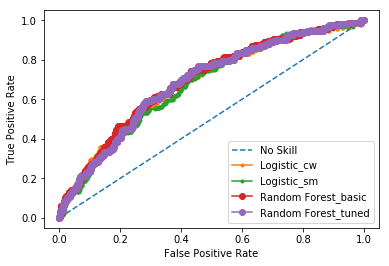

In [572]:
# predict probabilities
rf_prob = clf_rf.best_estimator_.predict_proba(X_test)
# keep probabilities for the positive outcome only
rf_prob = rf_prob[:,1]
#calculate scores
rf_auc_roc = roc_auc_score(y_test, rf_prob)
# summarize scores and compare with previous classifiers
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic_cw: ROC AUC=%.3f' % (lr_auc_roc_cw))
print('Logistic_sm: ROC AUC=%.3f' % (lr_auc_roc_sm))
print('Random_forest_basic: ROC AUC=%.3f' % (rf_auc_rocb))
print('Random_forest_tuned: ROC AUC=%.3f' % (rf_auc_roc))
# calculate roc curves
rf_fpr, rf_tpr, _rf = roc_curve(y_test, rf_prob)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr_cw, lr_tpr_cw, marker='.', label='Logistic_cw')
pyplot.plot(lr_fpr_sm, lr_tpr_sm, marker='.', label='Logistic_sm')
pyplot.plot(rf_fprb, rf_tprb, marker='o', label='Random Forest_basic')
pyplot.plot(rf_fpr, rf_tpr, marker='o', label='Random Forest_tuned')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

**Precision-recall** 

Logistic: f1=0.182 auc=0.123
Logistic: f1=0.168 auc=0.115
Random Forest_basic: f1=0.181 auc=0.143
Random Forest_tuned: f1=0.184 auc=0.136


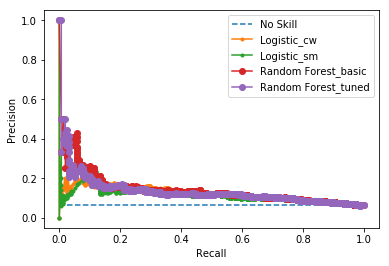

In [573]:
# precision, recall and f1
rf_precision, rf_recall, _rf_pr = precision_recall_curve(y_test, rf_prob)
rf_f1, rf_auc = f1_score(y_test, pred_rf), auc(rf_recall, rf_precision)
# summarize scores
print('Logistic: f1=%.3f auc=%.3f' % (lr_f1_cw, lr_auc_cw))
print('Logistic: f1=%.3f auc=%.3f' % (lr_f1_sm, lr_auc_sm))
print('Random Forest_basic: f1=%.3f auc=%.3f' % (rf_f1b, rf_aucb))
print('Random Forest_tuned: f1=%.3f auc=%.3f' % (rf_f1, rf_auc))
# plot the precision-recall curves
pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
pyplot.plot(lr_recall_cw, lr_precision_cw, marker='.', label='Logistic_cw')
pyplot.plot(lr_recall_sm, lr_precision_sm, marker='.', label='Logistic_sm')
pyplot.plot(rf_recallb, rf_precisionb, marker='o', label='Random Forest_basic')
pyplot.plot(rf_recall, rf_precision, marker='o', label='Random Forest_tuned')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [574]:
result['clf_rf_tuned'] = [cross_val_score(clf_rf.best_estimator_,X,y,scoring='recall',cv=5).mean(),rf_auc_roc,rf_auc,rf_f1]

The tuned is worse than basic. Some more tuning needed with GridSearch

In [589]:
result

,logreg_cw,logreg_sm,clf_rf_basic,clf_rf_tuned,clf_xgb_basic,clf_xgb_tuned
recall,0.485479,0.436362,0.570025,0.575927,0.070608,0.107921
auc_roc,0.683655,0.674220,0.693077,0.686995,0.708398,0.721943
auc_prec_rec,0.123323,0.114851,0.143199,0.135815,0.217349,0.221856
f1,0.182160,0.168007,0.180608,0.184466,0.195652,0.204878


## XGBoost
I have used several references: https://www.datacamp.com/community/tutorials/xgboost-in-python

In [356]:
#import library
import xgboost as xgb

#### 1) Classifier

In [485]:
# I will use the XGB Scikit-learn API/modules 
X_train_xgb = X_train.copy()
X_test_xgb = X_test.copy()
                                                   
clf_xgb = xgb.XGBClassifier(learning_rate = 0.1,
                            n_estimators=800,
                            min_samples_leaf=21,
                            max_features='sqrt',
                            max_depth=3,
                            class_weight='balanced',
                            score='recall',
                            random_state=42)


#### 2) Fit the model

In [486]:
clf_xgb.fit(X_train_xgb,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', class_weight='balanced',
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
              max_features='sqrt', min_child_weight=1, min_samples_leaf=21,
              missing=None, n_estimators=800, n_jobs=1, nthread=None,
              objective='binary:logistic', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, score='recall', seed=None,
              silent=None, subsample=1, verbosity=1)

In [578]:
#predict class values
pred_xgb = clf_xgb.predict(X_test_xgb)
#confussion matrix
print(confusion_matrix(y_test,pred_xgb))
print(classification_report(y_test,pred_xgb))

[[2229   15]
 [ 133   18]]
              precision    recall  f1-score   support

           0       0.94      0.99      0.97      2244
           1       0.55      0.12      0.20       151

    accuracy                           0.94      2395
   macro avg       0.74      0.56      0.58      2395
weighted avg       0.92      0.94      0.92      2395



#### 3) Metrics

**Roc - Auc**

No Skill: ROC AUC=0.500
Logistic_cw: ROC AUC=0.684
Logistic_sm: ROC AUC=0.674
Random_forest_basic: ROC AUC=0.693
Random_forest_tuned: ROC AUC=0.687
xgboost_basic: ROC AUC=0.708


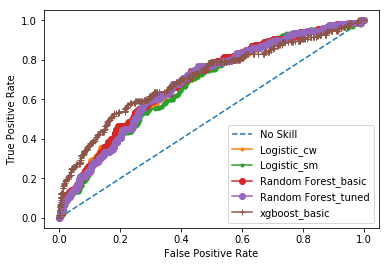

In [577]:
# predict probabilities
xgb_prob = clf_xgb.predict_proba(X_test_xgb)
# keep probabilities for the positive outcome only
xgb_prob = xgb_prob[:,1]
#calculate scores
xgb_auc_roc = roc_auc_score(y_test, xgb_prob)
# summarize scores and compare with previous classifiers
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic_cw: ROC AUC=%.3f' % (lr_auc_roc_cw))
print('Logistic_sm: ROC AUC=%.3f' % (lr_auc_roc_sm))
print('Random_forest_basic: ROC AUC=%.3f' % (rf_auc_rocb))
print('Random_forest_tuned: ROC AUC=%.3f' % (rf_auc_roc))
print('xgboost_basic: ROC AUC=%.3f' % (xgb_auc_roc))
# calculate roc curves
xgb_fpr, xgb_tpr, _xgb = roc_curve(y_test, xgb_prob)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr_cw, lr_tpr_cw, marker='.', label='Logistic_cw')
pyplot.plot(lr_fpr_sm, lr_tpr_sm, marker='.', label='Logistic_sm')
pyplot.plot(rf_fprb, rf_tprb, marker='o', label='Random Forest_basic')
pyplot.plot(rf_fpr, rf_tpr, marker='o', label='Random Forest_tuned')
pyplot.plot(xgb_fpr, xgb_tpr, marker='+', label='xgboost_basic')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

**Precision-recall**

Logistic: f1=0.182 auc=0.123
Logistic: f1=0.168 auc=0.115
Random Forest_basic: f1=0.181 auc=0.143
Random Forest_tuned: f1=0.184 auc=0.136
xgboost_basic: f1=0.196 auc=0.217


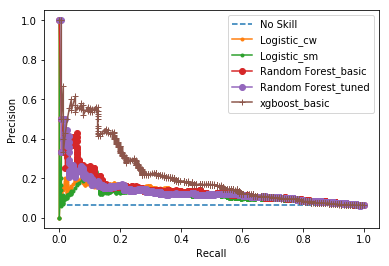

In [576]:
# precision, recall and f1
xgb_precision, xgb_recall, _xgb_pr = precision_recall_curve(y_test, xgb_prob)
xgb_f1, xgb_auc = f1_score(y_test, pred_xgb), auc(xgb_recall, xgb_precision)
# summarize scores
print('Logistic: f1=%.3f auc=%.3f' % (lr_f1_cw, lr_auc_cw))
print('Logistic: f1=%.3f auc=%.3f' % (lr_f1_sm, lr_auc_sm))
print('Random Forest_basic: f1=%.3f auc=%.3f' % (rf_f1b, rf_aucb))
print('Random Forest_tuned: f1=%.3f auc=%.3f' % (rf_f1, rf_auc))
print('xgboost_basic: f1=%.3f auc=%.3f' % (xgb_f1, xgb_auc))
# plot the precision-recall curves
pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
pyplot.plot(lr_recall_cw, lr_precision_cw, marker='.', label='Logistic_cw')
pyplot.plot(lr_recall_sm, lr_precision_sm, marker='.', label='Logistic_sm')
pyplot.plot(rf_recallb, rf_precisionb, marker='o', label='Random Forest_basic')
pyplot.plot(rf_recall, rf_precision, marker='o', label='Random Forest_tuned')
pyplot.plot(xgb_recall, xgb_precision, marker='+', label='xgboost_basic')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [579]:
result['clf_xgb_basic'] = [cross_val_score(clf_xgb,X_xgb,y_xgb,scoring='recall',cv=5).mean(),xgb_auc_roc,xgb_auc,xgb_f1]

Very bad results (does not differentiate classes). More fine tunning is needed for xgb

In [590]:
result

,logreg_cw,logreg_sm,clf_rf_basic,clf_rf_tuned,clf_xgb_basic,clf_xgb_tuned
recall,0.485479,0.436362,0.570025,0.575927,0.070608,0.107921
auc_roc,0.683655,0.674220,0.693077,0.686995,0.708398,0.721943
auc_prec_rec,0.123323,0.114851,0.143199,0.135815,0.217349,0.221856
f1,0.182160,0.168007,0.180608,0.184466,0.195652,0.204878


## XGBoost tunning

I am going to fine tune the XGboost hyperparameters to try to improve the result.   
I am going to follow the following approach taken from the article https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/:   

1) Choose a relatively high learning rate. Generally the default value of 0.1 works but somewhere between 0.05 to 0.2 should work for different problems  

2) Determine the optimum number of trees for this learning rate. This should range around 40-70. Remember to choose a value on which your system can work fairly fast. This is because it will be used for testing various scenarios and determining the tree parameters.

3) Tune tree-specific parameters for decided learning rate and number of trees. Note that we can choose different parameters to define a tree and I’ll take up an example here.

4) Lower the learning rate and increase the estimators proportionally to get more robust models.

In [226]:
#import library
import xgboost as xgb

**Estimator 1: clf_xgb_t1**  
1) Choose a relatively high learning rate. Generally the default value of 0.1 works but somewhere between 0.05 to 0.2 should work for different problems   

2) Determine the optimum number of trees for this learning rate. 

In [493]:
# Copy train and test info DF para XGB
X_train_xgb = X_train.copy()
X_test_xgb = X_test.copy()

param_grid={'n_estimators':np.arange(20,200,10)}

# Instanciate the classifier          
clf_xgb_t1 = GridSearchCV(estimator= xgb.XGBClassifier(learning_rate = 0.1,
                                                       min_samples_split = 25,
                                                       min_samples_leaf=20,
                                                       max_features='sqrt',
                                                       max_depth=8,
                                                       subsample=0.8,
                                                       random_state=42),
                          param_grid = param_grid,
                          scoring = 'recall',
                          cv= 5,
                          iid=False,
                          verbose=2,
                          n_jobs = 4)

# Fit
clf_xgb_t1.fit(X_train_xgb,y_train)

# Results
clf_xgb_t1.best_params_, clf_xgb_t1.best_score_

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   30.0s
[Parallel(n_jobs=4)]: Done  90 out of  90 | elapsed:  2.4min finished


({'n_estimators': 190}, 0.1032472613458529)

**Estimator 2: clf_xgb_t2**   
3) Tune tree-specific parameters for decided learning rate and number of trees. Note that we can choose different parameters to define a tree and I’ll take up an example here.

In [494]:
param_grid={'max_depth': np.arange(5,16,2),
            'min_samples_leaf': np.arange(10,50,10),
            'min_samples_split': np.arange(20,100,10),
            'max_features': ['sqrt','log2']}

# Instanciate the classifier          
clf_xgb_t2 = GridSearchCV(estimator= xgb.XGBClassifier(learning_rate = 0.1,
                                                       n_estimators = 190,                                                                                    
                                                       subsample=0.8,
                                                       random_state=42),
                          param_grid = param_grid,
                          scoring = 'recall',
                          cv= 5,
                          iid=False,
                          verbose=2,
                          n_jobs = 4)

# Fit
clf_xgb_t2.fit(X_train_xgb,y_train)

# Results
clf_xgb_t2.best_params_, clf_xgb_t2.best_score_

Fitting 5 folds for each of 384 candidates, totalling 1920 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  1.1min
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:  4.7min
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed: 11.4min
[Parallel(n_jobs=4)]: Done 640 tasks      | elapsed: 24.3min
[Parallel(n_jobs=4)]: Done 1005 tasks      | elapsed: 46.2min
[Parallel(n_jobs=4)]: Done 1450 tasks      | elapsed: 77.4min
[Parallel(n_jobs=4)]: Done 1920 out of 1920 | elapsed: 114.3min finished


({'max_depth': 9,
  'max_features': 'sqrt',
  'min_samples_leaf': 10,
  'min_samples_split': 20},
 0.10328638497652583)

**Estimator 3: clf_xgb_t3**   
3) Tune tree-specific parameters: max_features

In [496]:
param_grid={'max_features':np.arange(10,34,2)}

# Instanciate the classifier          
clf_xgb_t3 = GridSearchCV(estimator= xgb.XGBClassifier(learning_rate = 0.1,
                                                       n_estimators = 190, 
                                                       min_samples_leaf=10,
                                                       min_samples_split=20,
                                                       max_depth=9,
                                                       subsample=0.8,
                                                       random_state=42),
                          param_grid = param_grid,
                          scoring = 'recall',
                          cv= 5,
                          iid=False,
                          verbose=2,
                          n_jobs = 4)

# Fit
clf_xgb_t3.fit(X_train_xgb,y_train)

# Results
clf_xgb_t3.best_params_, clf_xgb_t3.best_score_

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  2.1min
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:  3.5min finished


({'max_features': 10}, 0.10328638497652583)

**Estimator 4: clf_xgb_t4**   
Tuning subsample

In [497]:
param_grid={'subsample':[0.6,0.7,0.75,0.8,0.85,0.9]}

# Instanciate the classifier          
clf_xgb_t4 = GridSearchCV(estimator= xgb.XGBClassifier(learning_rate = 0.1,
                                                       n_estimators = 190, 
                                                       min_samples_leaf=10,
                                                       min_samples_split=20,
                                                       max_depth=9,
                                                       max_features=10,
                                                       random_state=42),
                          param_grid = param_grid,
                          scoring = 'recall',
                          cv= 5,
                          iid=False,
                          verbose=2,
                          n_jobs = 4)

# Fit
clf_xgb_t4.fit(X_train_xgb,y_train)

# Results
clf_xgb_t4.best_params_, clf_xgb_t4.best_score_

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:  1.8min finished


({'subsample': 0.7}, 0.11451486697965571)

**Estimator 5: clf_xgb_t5**      
Tuning learning rate (as I reduced it I increase the n_estimators in the same proportion)

In [498]:
# Instanciate the classifier          
clf_xgb_t5 = xgb.XGBClassifier(learning_rate = 0.01,
                               n_estimators = 1900, 
                               min_samples_leaf=10,
                               min_samples_split=20,
                               max_depth=9,
                               max_features=10,
                               subsample=0.7,
                               random_state=42,
                               scoring = 'recall',
                               class_weight='balanced',
                               )

# Fit
clf_xgb_t5.fit(X_train_xgb,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', class_weight='balanced',
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              gamma=0, learning_rate=0.01, max_delta_step=0, max_depth=9,
              max_features=10, min_child_weight=1, min_samples_leaf=10,
              min_samples_split=20, missing=None, n_estimators=1900, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, scoring='recall',
              seed=None, silent=None, subsample=0.7, verbosity=1)

#### 3) Metrics

In [499]:
#predict class values
pred_xgb_t5 = clf_xgb_t5.predict(X_test_xgb)
#confussion matrix
print(confusion_matrix(y_test,pred_xgb_t5))
print(classification_report(y_test,pred_xgb_t5))

[[2211   33]
 [ 130   21]]
              precision    recall  f1-score   support

           0       0.94      0.99      0.96      2244
           1       0.39      0.14      0.20       151

    accuracy                           0.93      2395
   macro avg       0.67      0.56      0.58      2395
weighted avg       0.91      0.93      0.92      2395



**Roc - Auc**

No Skill: ROC AUC=0.500
Logistic_cw: ROC AUC=0.684
Logistic_sm: ROC AUC=0.674
Random_forest_basic: ROC AUC=0.693
Random_forest_tuned: ROC AUC=0.687
xgboost_basic: ROC AUC=0.708
xgboost_tuned: ROC AUC=0.722


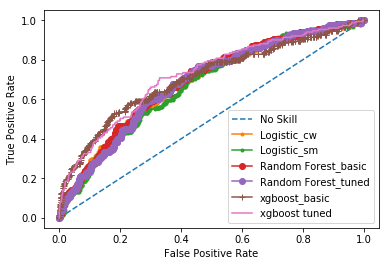

In [581]:
# predict probabilities
xgb_prob_t5 = clf_xgb_t5.predict_proba(X_test_xgb)
# keep probabilities for the positive outcome only
xgb_prob_t5 = xgb_prob_t5[:,1]
#calculate scores
xgb_auc_roc_t5 = roc_auc_score(y_test, xgb_prob_t5)
# summarize scores and compare with previous classifiers
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic_cw: ROC AUC=%.3f' % (lr_auc_roc_cw))
print('Logistic_sm: ROC AUC=%.3f' % (lr_auc_roc_sm))
print('Random_forest_basic: ROC AUC=%.3f' % (rf_auc_rocb))
print('Random_forest_tuned: ROC AUC=%.3f' % (rf_auc_roc))
print('xgboost_basic: ROC AUC=%.3f' % (xgb_auc_roc))
print('xgboost_tuned: ROC AUC=%.3f' % (xgb_auc_roc_t5))
# calculate roc curves
xgb_fpr_t5, xgb_tpr_t5, _xgb_t5 = roc_curve(y_test, xgb_prob_t5)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr_cw, lr_tpr_cw, marker='.', label='Logistic_cw')
pyplot.plot(lr_fpr_sm, lr_tpr_sm, marker='.', label='Logistic_sm')
pyplot.plot(rf_fprb, rf_tprb, marker='o', label='Random Forest_basic')
pyplot.plot(rf_fpr, rf_tpr, marker='o', label='Random Forest_tuned')
pyplot.plot(xgb_fpr, xgb_tpr, marker='+', label='xgboost_basic')
pyplot.plot(xgb_fpr_t5, xgb_tpr_t5, label='xgboost tuned')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

**Precision-recall** 

Logistic: f1=0.182 auc=0.123
Logistic: f1=0.168 auc=0.115
Random Forest_basic: f1=0.181 auc=0.143
Random Forest_tuned: f1=0.184 auc=0.136
xgboost_basic: f1=0.196 auc=0.217
xgboost tuned: f1=0.205 auc=0.222


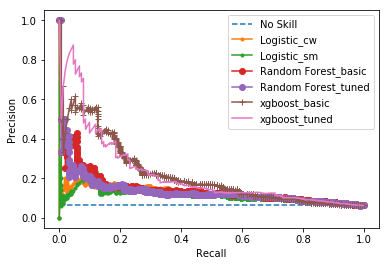

In [582]:
# precision, recall and f1
xgb_precision_t5, xgb_recall_t5, _xgb_pr_t5 = precision_recall_curve(y_test, xgb_prob_t5)
xgb_f1_t5, xgb_auc_t5 = f1_score(y_test, pred_xgb_t5), auc(xgb_recall_t5, xgb_precision_t5)
# summarize scores
print('Logistic: f1=%.3f auc=%.3f' % (lr_f1_cw, lr_auc_cw))
print('Logistic: f1=%.3f auc=%.3f' % (lr_f1_sm, lr_auc_sm))
print('Random Forest_basic: f1=%.3f auc=%.3f' % (rf_f1b, rf_aucb))
print('Random Forest_tuned: f1=%.3f auc=%.3f' % (rf_f1, rf_auc))
print('xgboost_basic: f1=%.3f auc=%.3f' % (xgb_f1, xgb_auc))
print('xgboost tuned: f1=%.3f auc=%.3f' % (xgb_f1_t5, xgb_auc_t5))
# plot the precision-recall curves
pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
pyplot.plot(lr_recall_cw, lr_precision_cw, marker='.', label='Logistic_cw')
pyplot.plot(lr_recall_sm, lr_precision_sm, marker='.', label='Logistic_sm')
pyplot.plot(rf_recallb, rf_precisionb, marker='o', label='Random Forest_basic')
pyplot.plot(rf_recall, rf_precision, marker='o', label='Random Forest_tuned')
pyplot.plot(xgb_recall, xgb_precision, marker='+', label='xgboost_basic')
pyplot.plot(xgb_recall_t5, xgb_precision_t5, label='xgboost_tuned')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [583]:
result['clf_xgb_tuned'] = [cross_val_score(clf_xgb_t5,X_xgb,y_xgb,scoring='recall',cv=5).mean(),
                          xgb_auc_roc_t5,xgb_auc_t5,xgb_f1_t5]

## Global results

Very bad results:
- The best recall and thus the one that better identifies classes, is obtained with tuned Random Forest (clf_rf)
- Xgb_tuned is the one with the best rest of metrics but the recall is awful. When it decides that the prediction is '1' (Close local), it does it with a higher precission but in the end, it is less trustworthy to identify classes.


In [591]:
result

,logreg_cw,logreg_sm,clf_rf_basic,clf_rf_tuned,clf_xgb_basic,clf_xgb_tuned
recall,0.485479,0.436362,0.570025,0.575927,0.070608,0.107921
auc_roc,0.683655,0.674220,0.693077,0.686995,0.708398,0.721943
auc_prec_rec,0.123323,0.114851,0.143199,0.135815,0.217349,0.221856
f1,0.182160,0.168007,0.180608,0.184466,0.195652,0.204878


I check whether some of the probabilities are higher enough (>.9) to be sure of saying it is going to close. I get some results with XGboost. I will prepare an descriptive analysis based on Tableau and I will come back to try a better prediction afterwards

In [585]:
X_test[rf_prob >.9]

,loc_dist_act,ab_dist_17_19,ab_dist_act_17_19_rate,total_ab_act_17_19_rate,total_ab_dist_17_19_rate,loc_barrio,ab_barrio_17_19,ab_barrio_act_17_19_rate,total_ab_barr_17_19_rate,total_na_barr_rate,lon,lat,num_act,Mujeres,Densidad (Habitantes / Ha.),Edad promedio,Extranjero fuera barrio fin semana,ratio_t_total,id_distrito_local_1,id_distrito_local_2,id_distrito_local_3,id_distrito_local_4,id_distrito_local_5,id_distrito_local_6,id_distrito_local_7,id_distrito_local_8,id_distrito_local_9,id_distrito_local_10,id_distrito_local_11,id_distrito_local_12,id_distrito_local_13,id_distrito_local_14,id_distrito_local_15,id_distrito_local_16,id_distrito_local_17,id_distrito_local_18,id_distrito_local_19,id_distrito_local_20,id_distrito_local_21,id_epigrafe_463101,id_epigrafe_472201,id_epigrafe_472202,id_epigrafe_472203,id_epigrafe_472204,id_epigrafe_472205,id_epigrafe_472206,id_epigrafe_472207,id_epigrafe_472302,id_epigrafe_472402,id_epigrafe_472403,id_epigrafe_472404,id_epigrafe_472407,id_epigrafe_472907,id_epigrafe_476403,id_epigrafe_476501,id_epigrafe_477602,id_epigrafe_750003,id_epigrafe_900001,id_epigrafe_931008,id_epigrafe_932002,id_epigrafe_952005,id_epigrafe_960205,id_epigrafe_960901,id_epigrafe_960902,dist_type_1,dist_type_2,dist_type_3,ab_17_19_0,ab_17_19_1


In [586]:
X_test[xgb_prob_t5 >.9]

,loc_dist_act,ab_dist_17_19,ab_dist_act_17_19_rate,total_ab_act_17_19_rate,total_ab_dist_17_19_rate,loc_barrio,ab_barrio_17_19,ab_barrio_act_17_19_rate,total_ab_barr_17_19_rate,total_na_barr_rate,lon,lat,num_act,Mujeres,Densidad (Habitantes / Ha.),Edad promedio,Extranjero fuera barrio fin semana,ratio_t_total,id_distrito_local_1,id_distrito_local_2,id_distrito_local_3,id_distrito_local_4,id_distrito_local_5,id_distrito_local_6,id_distrito_local_7,id_distrito_local_8,id_distrito_local_9,id_distrito_local_10,id_distrito_local_11,id_distrito_local_12,id_distrito_local_13,id_distrito_local_14,id_distrito_local_15,id_distrito_local_16,id_distrito_local_17,id_distrito_local_18,id_distrito_local_19,id_distrito_local_20,id_distrito_local_21,id_epigrafe_463101,id_epigrafe_472201,id_epigrafe_472202,id_epigrafe_472203,id_epigrafe_472204,id_epigrafe_472205,id_epigrafe_472206,id_epigrafe_472207,id_epigrafe_472302,id_epigrafe_472402,id_epigrafe_472403,id_epigrafe_472404,id_epigrafe_472407,id_epigrafe_472907,id_epigrafe_476403,id_epigrafe_476501,id_epigrafe_477602,id_epigrafe_750003,id_epigrafe_900001,id_epigrafe_931008,id_epigrafe_932002,id_epigrafe_952005,id_epigrafe_960205,id_epigrafe_960901,id_epigrafe_960902,dist_type_1,dist_type_2,dist_type_3,ab_17_19_0,ab_17_19_1
7041,0.11608,2.219717,0.314365,-0.852832,1.024044,0.284825,0.676913,0.795089,0.473899,-0.52152,-0.555091,-0.19514,-0.499649,-0.722731,0.991913,-0.064432,2.786552,-0.538465,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
7066,0.11608,2.219717,0.314365,-0.852832,1.024044,0.284825,0.676913,0.795089,0.473899,-0.52152,-0.555091,-0.19514,-0.499649,-0.722731,0.991913,-0.064432,2.786552,-0.538465,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0


## Feature selection
I found a code sample and article about an automated way of evaluating the number of features to use: https://machinelearningmastery.com/feature-importance-and-feature-selection-with-xgboost-in-python/

### Random Forest

**Plot feature_importance** 
To get the feature_importance_ I will use the basic classifier (clf_rfb) because does not work with Randomizer and pipelines

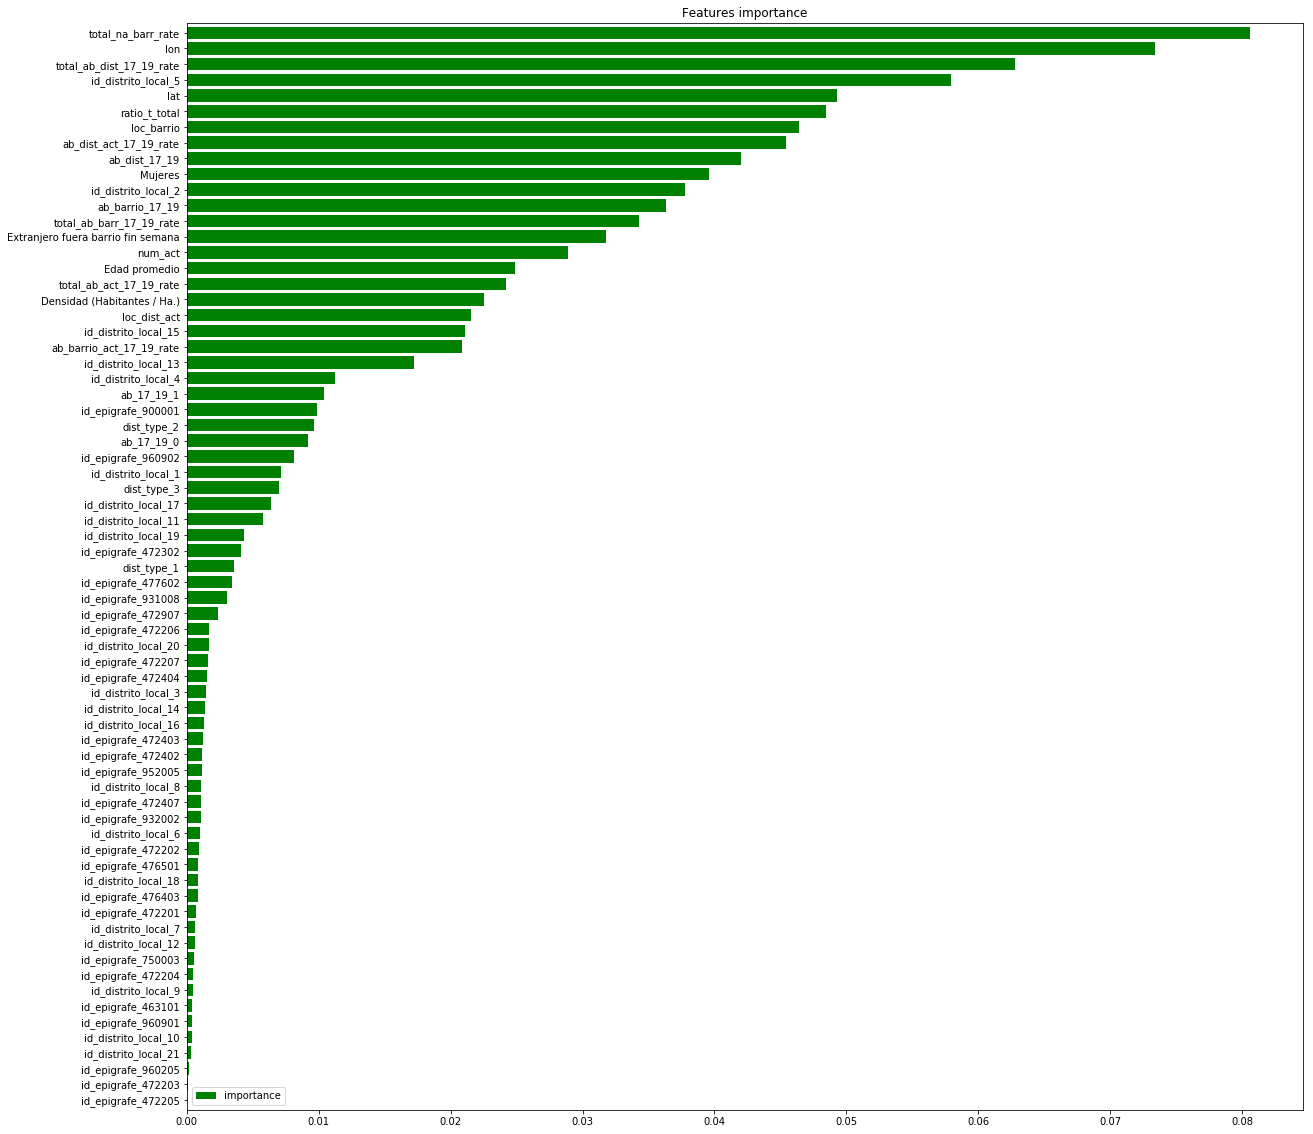

In [602]:
clf_rf2 = RandomForestClassifier(n_estimators=500,
                                 min_samples_leaf=14,
                                 max_features='auto',
                                 max_depth=3,
                                 class_weight='balanced',
                                random_state=42)


clf_rf2.fit(X_train,y_train)

importantes_rf2 = pd.DataFrame(clf_rf2.feature_importances_,
                           columns=['importance'],
                          index=X_train.columns).sort_values('importance', ascending=True)


importantes_rfb.plot(kind='barh',width=0.8, color='green',title='Features importance', figsize=[20,20])
plt.show()

**Recommended number of features**     
I found a code sample and article about an automated way of evaluating the number of features to use that I have I adapted to my code. It uses SelectFromModel from sklearn. It is a meta-transformer for selecting features based on weights importance.: https://machinelearningmastery.com/feature-importance-and-feature-selection-with-xgboost-in-python/

In [612]:
# use feature importance for feature selection
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import recall_score

# make predictions for test data and evaluate
y_pred = clf_rf2.predict(X_test)
predictions = [round(value) for value in y_pred]
recall_ = recall_score(y_test, predictions)
print("Recall: %.2f%%" % (recall_ * 100.0))

# Fit model using each importance as a threshold
thresholds = sort(clf_rf2.feature_importances_)
for thresh in thresholds:
# select features using threshold
    selection = SelectFromModel(clf_rf2, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_train)
# train model
    selection_model = RandomForestClassifier(n_estimators=500,
                                 min_samples_leaf=14,
                                 max_features='auto',
                                 max_depth=3,
                                 class_weight='balanced',
                                random_state=42)
    selection_model.fit(select_X_train, y_train)
    # eval model
    select_X_test = selection.transform(X_test)
    y_pred = selection_model.predict(select_X_test)
    predictions = [round(value) for value in y_pred]
    recall_ = recall_score(y_test, predictions)
    print("Thresh=%.3f, n=%d, Recall: %.2f%%" % (thresh, select_X_train.shape[1], recall_*100.0))


Recall: 62.91%
Thresh=0.000, n=69, Recall: 62.91%
Thresh=0.000, n=68, Recall: 65.56%
Thresh=0.000, n=67, Recall: 63.58%
Thresh=0.000, n=66, Recall: 64.24%
Thresh=0.000, n=65, Recall: 63.58%
Thresh=0.000, n=64, Recall: 63.58%
Thresh=0.000, n=63, Recall: 62.91%
Thresh=0.000, n=62, Recall: 62.91%
Thresh=0.001, n=61, Recall: 63.58%
Thresh=0.001, n=60, Recall: 64.24%
Thresh=0.001, n=59, Recall: 62.91%
Thresh=0.001, n=58, Recall: 64.24%
Thresh=0.001, n=57, Recall: 64.90%
Thresh=0.001, n=56, Recall: 62.91%
Thresh=0.001, n=55, Recall: 64.24%
Thresh=0.001, n=54, Recall: 63.58%
Thresh=0.001, n=53, Recall: 64.24%
Thresh=0.001, n=52, Recall: 63.58%
Thresh=0.001, n=51, Recall: 64.24%
Thresh=0.001, n=50, Recall: 63.58%
Thresh=0.001, n=49, Recall: 63.58%
Thresh=0.001, n=48, Recall: 63.58%
Thresh=0.001, n=47, Recall: 63.58%
Thresh=0.001, n=46, Recall: 64.24%
Thresh=0.001, n=45, Recall: 63.58%
Thresh=0.001, n=44, Recall: 64.24%
Thresh=0.001, n=43, Recall: 62.25%
Thresh=0.002, n=42, Recall: 64.90%
Thres

According to previous analysis, the highest recall_score is obtain by selecting between 4-6 features althogh it does not vary too much (since I did a feature selection at the beginning,it seems that I have not left not "relevant" variables). Just for the sake of the study, let's see which are this 6 features:   
- total_na_barr_rate: No activity commercial premises rate
- lon: Longitude - (here I have doubts - I take out id_barrio)
- total_ab_dist_17_18_rate: open commercial premises since 2017 rate
- id_distrito_local_5: Chamartin district
- lat: latitude (same as longitude)
- ration_t_total: working floating population in a week rate

In [617]:
#I order in descending way
importantes_rf2_d = pd.DataFrame(clf_rf2.feature_importances_,
                           columns=['importance'],
                          index=X_train.columns).sort_values('importance', ascending=False)
importantes_rf2_d.iloc[0:6]

,importance
total_na_barr_rate,0.080578
lon,0.073413
total_ab_dist_17_19_rate,0.062766
id_distrito_local_5,0.057924
lat,0.049309
ratio_t_total,0.048435


And the last: analysis of the results: check whether important categorical variables are correlated to target

In [629]:
def plot_categorical(df, var_name, target_name, width=7, height=5, color='#13A844'):
 

    # target vs category rate:

    proporcion_target =  df.loc[:, [target_name, var_name]].groupby([var_name]).mean()
 

    # count per category

    distribucion_categoria = df.loc[:, [target_name, var_name]].groupby([var_name]).count()
 

    # plotting

    fig = plt.figure(figsize=(width, height))

    ax = distribucion_categoria[target_name].plot(kind='bar', color=color)

    ax.set_ylabel('Number of samples', color=color)

    ax2 = ax.twinx()

    ax2.grid(False)

    ax2.plot(proporcion_target[target_name].values, color='r', linestyle='-', alpha=0.9, marker = '.', markeredgewidth = 2, linewidth=1.0)

    ax2.set_ylabel('target ratio',color='r')

    plt.title('Variable description ' + var_name)

    plt.show()

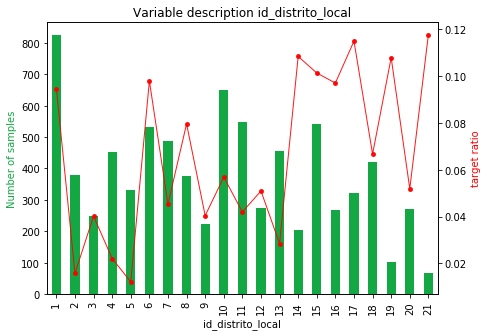

In [630]:
plot_categorical(df_locals_, 'id_distrito_local', 'target', width=7, height=5, color='#13A844')

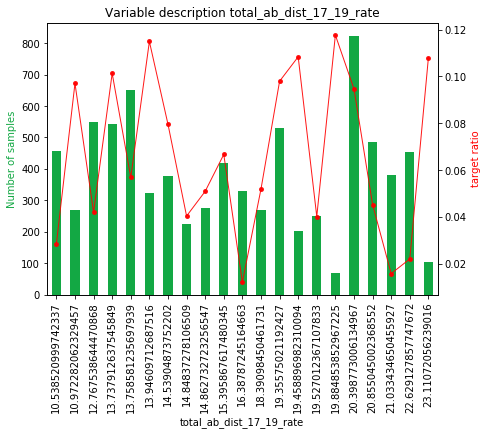

In [631]:
plot_categorical(df_locals_, 'total_ab_dist_17_19_rate', 'target', width=7, height=5, color='#13A844')

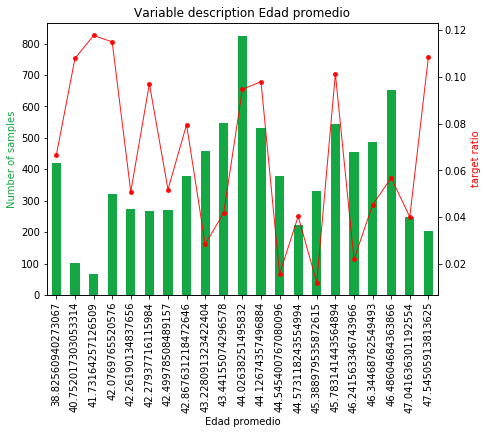

In [634]:
plot_categorical(df_locals_, 'Edad promedio', 'target', width=7, height=5, color='#13A844')

### Xgboost

**Plot importance**
The same with Xgboost

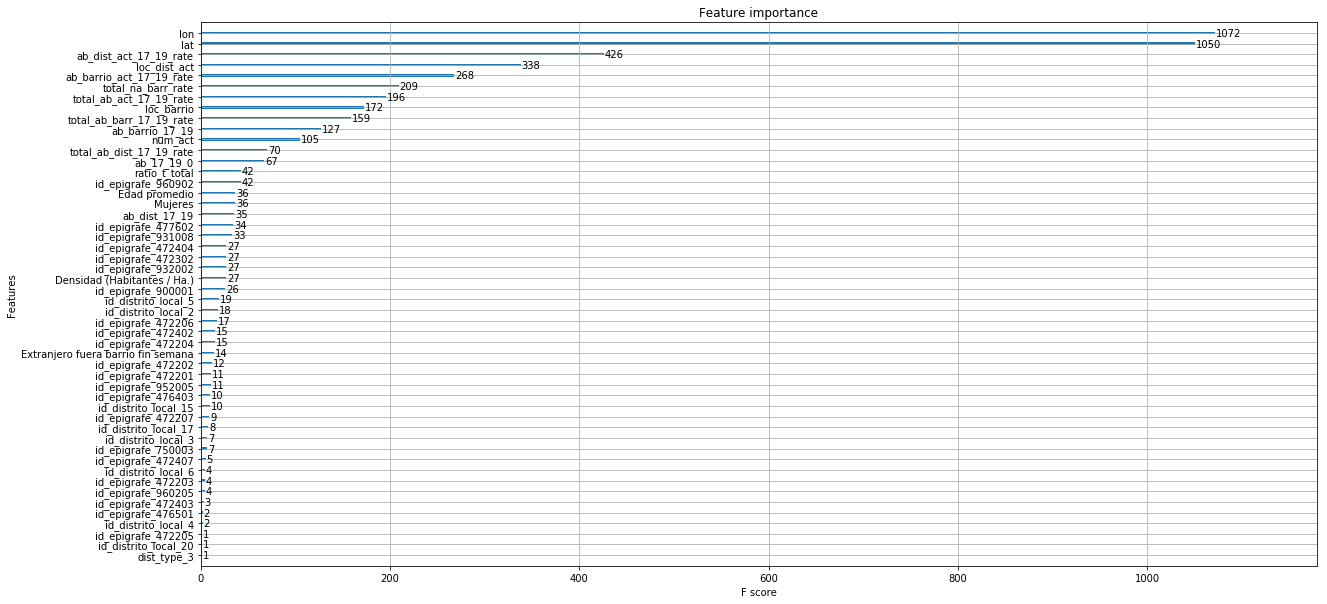

In [646]:
from xgboost import plot_importance
plt.rcParams["figure.figsize"] = (20, 10)
plot_importance(clf_xgb)
plt.show()

## Optimal Cut off
I found a function in Stack overflow to Find_Optimal_Cutoff (https://stackoverflow.com/questions/28719067/roc-curve-and-cut-off-point-python)

### Random Forest

[]

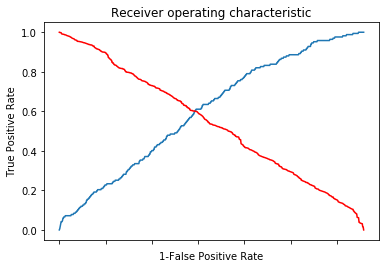

In [52]:
# The optimal cut off would be where tpr is high and fpr is low
# tpr - (1-fpr) is zero or near to zero is the optimal cut off point

i = np.arange(len(rf_tpr)) # index for df
roc = pd.DataFrame({'fp' : pd.Series(rf_fpr, index=i),'tp' : pd.Series(rf_tpr, index = i)
                    , '1-fp' : pd.Series(1-rf_fpr, index = i), 
                    'tf' : pd.Series(rf_tpr - (1-rf_fpr), index = i),
                    'thresholds' : pd.Series(_rf, index = i)})
roc.loc[(roc.tf-0).abs().argsort()[:1]]

# Plot tpr vs 1-fpr
fig, ax = plt.subplots()
plt.plot(roc['tp'])
plt.plot(roc['1-fp'], color = 'red')
plt.xlabel('1-False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
ax.set_xticklabels([])

In [53]:
""" Find the optimal probability cutoff point for a classification model related to event rate
    Parameters
    ----------
    target : Matrix with dependent or target data, where rows are observations

    predicted : Matrix with predicted data, where rows are observations

    Returns
    -------     
    list type, with optimal cutoff value

    """
def Find_Optimal_Cutoff(target, predicted):
    fp, tp, thresholds = roc_curve(target, predicted)
    i = np.arange(len(tp)) 
    roc = pd.DataFrame({'tf' : pd.Series(tp-(1-fp), index=i),
                        'thresholds' : pd.Series(thresholds, index=i)})
    roc_t = roc.loc[(roc.tf-0).abs().argsort()[:1]]

# return list(roc_t['thresholds'])
    return float(roc_t['thresholds'])
  

# Add prediction probability to dataframe
data = pd.DataFrame()
data['pred_proba'] = pd.Series(rf_prob)
#data['target'] = pd.Series(y_test)

# Find optimal probability threshold
threshold = Find_Optimal_Cutoff(y_test,data['pred_proba'])
print(threshold)


# Find prediction to the dataframe applying threshold
data['pred'] = data['pred_proba'].map(lambda x: 1 if x > threshold else 0)

# Print confusion Matrix
print(confusion_matrix(y_test, data['pred']))
print(classification_report(y_test,data['pred']))

0.5235092962936432
[[1427  946]
 [  67  100]]
              precision    recall  f1-score   support

           0       0.96      0.60      0.74      2373
           1       0.10      0.60      0.16       167

    accuracy                           0.60      2540
   macro avg       0.53      0.60      0.45      2540
weighted avg       0.90      0.60      0.70      2540



As we can see, the optimum cut-off is 0.52. Aproximately the one 'by default'. No relevant diferences with regards previous results

## Save the model

In [505]:
import pickle
# save models to disk (tined RF and tuned xgb)
pickle.dump(clf_rf,open('clf_rf.pkl','wb'))
pickle.dump(clf_xgb_t5,open('clf_xgb_tuned.pkl','wb'))

In [37]:
#load model from disk
clf_rf = pickle.load(open('clf_rf.pkl', 'rb'))
clf_xgb_t5 = pickle.load(open('clf_xgb_tuned.pkl', 'rb'))